In [1]:
!git clone https://github.com/cye2020/TSF-SPI.git

Cloning into 'TSF-SPI'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 336 (delta 68), reused 78 (delta 38), pack-reused 223
Receiving objects: 100% (336/336), 388.08 KiB | 5.88 MiB/s, done.
Resolving deltas: 100% (187/187), done.


In [2]:
cd TSF-SPI/

/kaggle/working/TSF-SPI


In [3]:
!git pull

Already up to date.


In [4]:
!pip install torchsummary
!pip install optuna

  Obtaining dependency information for torchsummary from https://files.pythonhosted.org/packages/7d/18/1474d06f721b86e6a9b9d7392ad68bed711a02f3b61ac43f13c719db50a6/torchsummary-1.5.1-py3-none-any.whl.metadata


In [5]:
import os
import warnings

# User-defined Data preprocessor
from utils.data_loader import CustomDataLoader
from utils.spliter import WindowGenerator

# Dataframe
import pandas as pd
import numpy as np
from itertools import chain, combinations
import matplotlib.pyplot as plt

# Seed
import torch
import random

# Models
from torch_models.cnn import CNN
from torch_models.rnn import RNN
from prophet import Prophet


# predict result
from utils.plot_util import plot
from utils.evaluation import printResult

import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
# from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import optuna
from optuna import Trial

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
data = pd.read_csv('./data/kospi.csv').dropna()
data

,Date,Kospi,USD/KRW,GDP,IAIP,LIR,M1,disease
0,2010-01-04,1696.140015,1132.400024,1143.67,79.3,5.350,59.71815,0
1,2010-01-05,1690.619995,1141.300049,1143.67,79.3,5.350,59.71815,0
2,2010-01-06,1705.319946,1130.400024,1143.67,79.3,5.350,59.71815,0
3,2010-01-07,1683.449951,1134.900024,1143.67,79.3,5.350,59.71815,0
4,2010-01-08,1695.260010,1123.099976,1143.67,79.3,5.350,59.71815,0
...,...,...,...,...,...,...,...,...
3509,2024-04-01,2747.860107,1345.310059,1673.92,105.5,3.353,187.20330,0
3510,2024-04-02,2753.159912,1355.530029,1673.92,105.5,3.353,187.20330,0
3511,2024-04-03,2706.969971,1350.729980,1673.92,105.5,3.353,187.20330,0
3512,2024-04-04,2742.000000,1344.839966,1673.92,105.5,3.353,187.20330,0


In [8]:
# data_loader = CustomDataLoader()
# Target = 'Kospi'

# # features = [Target, 'USD/KRW', 'GDP', 'IAIP', 'LIR', 'M1', 'disease']
# features = [Target, 'USD/KRW', 'GDP', 'IAIP', 'LIR', 'M1', 'disease']


# train, test, date_lists = data_loader.load_csv(path='./data/kospi.csv', 
#                                                 features=np.concatenate((['Date'],features), axis=0), 
#                                                 split_date='2019-12-31')


split_date_train = '2018-12-31'
split_date_valid = '2021-12-31'

# train, valid, test 데이터 나누기
train_data = data.loc[data['Date'] <= split_date_train].copy()
valid_data = data.loc[(data['Date'] > split_date_train) & (data['Date'] <= split_date_valid)].copy()
train_valid_data = data.loc[data['Date'] <= split_date_valid].copy()
vaild_test_data = data.loc[data['Date'] > split_date_train].copy()
test_data = data.loc[data['Date'] > split_date_valid].copy()

In [9]:
# 결과 출력
print("Train 데이터 크기:", len(train_data))
print("Valid 데이터 크기:", len(valid_data))
print("Test 데이터 크기:", len(test_data))

Train 데이터 크기: 2217
Valid 데이터 크기: 742
Test 데이터 크기: 555


In [10]:
# boolarr = np.isnan(test)
# boolarr.sum()
# np.count_nonzero(boolarr)

In [11]:
data.rename(columns={'Date': 'ds', 'Kospi': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

train_data.rename(columns={'Date': 'ds', 'Kospi': 'y'}, inplace=True)
train_data['ds'] = pd.to_datetime(train_data['ds'])

valid_data.rename(columns={'Date': 'ds', 'Kospi': 'y'}, inplace=True)
valid_data['ds'] = pd.to_datetime(valid_data['ds'])

test_data.rename(columns={'Date': 'ds', 'Kospi': 'y'}, inplace=True)
test_data['ds'] = pd.to_datetime(test_data['ds'])

train_valid_data.rename(columns={'Date': 'ds', 'Kospi': 'y'}, inplace=True)
train_valid_data['ds'] = pd.to_datetime(train_valid_data['ds'])

vaild_test_data.rename(columns={'Date': 'ds', 'Kospi': 'y'}, inplace=True)
vaild_test_data['ds'] = pd.to_datetime(vaild_test_data['ds'])


additional_columns = ['USD/KRW', 'GDP', 'IAIP', 'LIR', 'M1', 'disease']

# 가능한 모든 조합의 리스트 생성
all_combinations = []
for r in range(1, len(additional_columns) + 1):
    all_combinations.extend(combinations(additional_columns, r))

regressor_combinations = ['_'.join(combination) for combination in all_combinations]

In [12]:


# prophet_model = Prophet(daily_seasonality=True)

# # 다른 변수들을 regressor로 추가
# additional_columns = ['USD/KRW', 'GDP', 'IAIP', 'LIR', 'M1', 'disease']
# for column in additional_columns:
#     prophet_model.add_regressor(column)


# prophet_model.fit(train)

# future = prophet_model.make_future_dataframe(periods=len(test))
# # 예측하려는 기간에 대한 추가 변수의 값을 future 데이터프레임에 추가


# for col in additional_columns:
#     future[col] = data[col].values


# forecast = prophet_model.predict(future)

In [13]:
def train(train_data, changepoints, changepoints_range, seasonality_mode, growth, regressors, cap=None):
    # Changepoints 랜덤 생성
    train_range = train_data['ds'].max() - train_data['ds'].min()
    changepoints = sorted(random.sample(list(train_data['ds']), changepoints))

    if growth == 'logistic':
        train_data['cap'] = cap  # 용량 값 설정
    
    # Prophet 모델 생성 및 학습
    model = Prophet(
        changepoints=changepoints,
        changepoint_range=changepoints_range,
        seasonality_mode=seasonality_mode,
        growth=growth,
    )
    
    columns = regressors.split('_')
    
    for col in columns:
        model.add_regressor(col)
        
    model.fit(train_data)

    return model

In [14]:
def test(model, test_data, total_data, regressors=[], growth='', cap=0, **kwargs):
    columns = regressors.split('_')
    
    # 예측 및 평가
    future = model.make_future_dataframe(periods=len(test_data), include_history=False)
    
    for col in columns:
        future[col] = test_data[col].values
        
    if growth == 'logistic':
        future['cap'] = cap  # 용량 값 설정
    
    forecast = model.predict(future)
    rmse = np.sqrt(mean_squared_error(test_data["y"], forecast["yhat"]))

    return rmse, forecast

In [15]:
def objective(trial: Trial) -> float:
    # 하이퍼파라미터 설정
    changepoints = trial.suggest_int("changepoints", 1, 10)
    changepoints_range = trial.suggest_float("changepoints_range", 0.8, 1.0)
    seasonality_mode = trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"])
    growth = trial.suggest_categorical("growth", ["linear", "logistic"])
    
    regressors = trial.suggest_categorical("regressors", regressor_combinations)
    
    params = {'changepoints': changepoints, 'changepoints_range': changepoints_range, 'seasonality_mode': seasonality_mode, 'growth': growth, 'regressors': regressors}
    
    if growth == 'logistic':
        cap = trial.suggest_float("cap", 100, 1000)  # 용량 값 제공
        params['cap'] = cap
    
    model = train(train_data, **params)
    rmse, forecast = test(model, valid_data, train_valid_data, **params)
    
    return rmse

In [16]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

best_params = study.best_params
print(f"최적의 하이퍼파라미터: {best_params}")

[I 2024-04-07 07:07:29,992] A new study created in memory with name: no-name-24713fe7-105f-45ec-87ac-ee7ce64df665
07:07:30 - cmdstanpy - INFO - Chain [1] start processing
07:07:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-04-07 07:07:35,650] Trial 0 finished with value: 3129.9790408519575 and parameters: {'changepoints': 2, 'changepoints_range': 0.8173684205732048, 'seasonality_mode': 'multiplicative', 'growth': 'logistic', 'regressors': 'USD/KRW_M1_disease', 'cap': 387.9315905327821}. Best is trial 0 with value: 3129.9790408519575.
07:07:35 - cmdstanpy - INFO - Chain [1] start processing
07:07:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-04-07 07:07:41,080] Trial 1 finished with value: 2086.468181280282 and parameters: {'changepoints': 4, 'changepoints_range': 0.8344720790589222, 'seasonality_mode': 'additive', 'growth': 'logistic', 'regressors': 'USD/KRW_LIR_M1', 'cap': 940.7740449851955}. Best is trial 1 with value: 2086.468181280282.
07:07:41 - cmdstanpy -

최적의 하이퍼파라미터: {'changepoints': 1, 'changepoints_range': 0.9636373093897851, 'seasonality_mode': 'additive', 'growth': 'linear', 'regressors': 'USD/KRW_LIR_M1'}


In [17]:
model = train(train_valid_data, **best_params)  

07:10:57 - cmdstanpy - INFO - Chain [1] start processing
07:10:57 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
rmse, forecast = test(model, test_data, data, **best_params)

In [19]:
forecast['ds'].iloc[:] = pd.to_datetime(test_data['ds']).iloc[:]

In [20]:
forecast['ds']

0     2022-01-04
1     2022-01-05
2     2022-01-06
3     2022-01-07
4     2022-01-10
         ...    
550   2024-04-01
551   2024-04-02
552   2024-04-03
553   2024-04-04
554   2024-04-05
Name: ds, Length: 555, dtype: datetime64[ns]

In [21]:
def plot_stock_forecast(data, forecast):
    plt.figure(figsize=(12, 6))
    plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='red')
    plt.plot(pd.to_datetime(data['ds']), data['y'], label='Actual', color='blue')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.5)
    plt.title('Stock Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

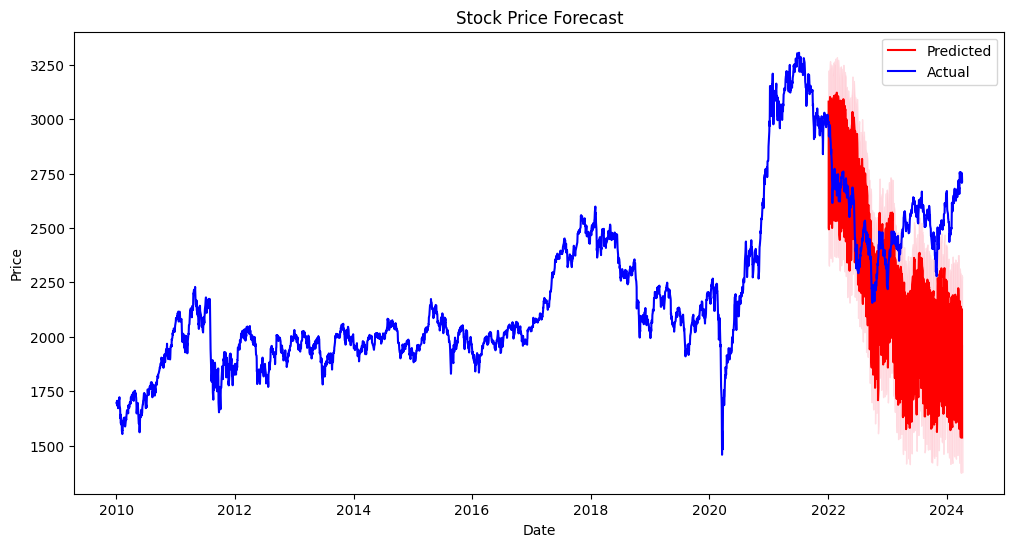

In [22]:
plot_stock_forecast(data, forecast)

In [23]:
# printResult(date_lists[2], test_cnn_y, test_cnn_predict, Target, features)

In [24]:
# test_cnn_x[-1]